# PyTorch - Autograd (is what we need.)

Advanced Learning 2025





For SUBMISSION:  
  
Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 212377717
~~~

~~~
STUDENT GIT LINK: https://github.com/yaelevy/Computational-Learning-and-Data-Analysis/tree/main/ex1
~~~

In Addition, don't forget to add your ID to the files:  
`PS1_Part3_Autograd_2025_ID_[212377717].html`  



This part of the problem-set is divided into 2 sections: (a) a short introduction to PyTorch autograd, and (b) some practice questions.      
The practice questions cover calculating the gradients and updating the weights of a statistical model (linear regression), with and without PyTorch autograd.

##  A Short Intro to PyTorch Autograd

In PyTorch, autograd, short for automatic differentiation, is a core functionality that empowers you to efficiently calculate gradients during deep learning model training. It acts as a computational engine that automatically tracks the operations performed on your tensors and calculates the gradients of any loss function with respect to the model's learnable parameters.

**Why is Autograd Important?**

* Gradient Calculation: Deep learning relies heavily on gradient-based optimization algorithms like stochastic gradient descent (SGD). These algorithms adjust the weights and biases (learnable parameters) of your model based on the gradients of the loss function. Autograd automates this process, saving you from manually calculating complex derivatives.
* Efficient Backpropagation: Backpropagation is the algorithm at the heart of training deep neural networks. It propagates the error (loss) backward through the network, allowing the model to adjust its parameters in the direction that minimizes the loss. Autograd streamlines this process, making training more efficient.

**How Does Autograd Work?**

* Tracking Operations: When you enable autograd mode (with `torch.autograd.record_grad()`), PyTorch creates a computational graph in the background. This graph tracks all the operations performed on your tensors

* Backward Pass: Once you calculate a loss function (which typically depends on the output of your model), you can call the `backward()` method on the loss tensor. This triggers the backward pass through the computational graph.

* Gradient Calculation: As the backward pass traverses the graph, autograd computes the gradients of the loss function with respect to each learnable parameter in the network. These gradients indicate how much a specific parameter contributed to the overall loss.

* Parameter Update: By utilizing these gradients, optimization algorithms like SGD update the model's learnable parameters in a direction that minimizes the loss function. This iterative process continues until the model converges (achieves a desired level of performance).

**Key Points about Autograd:**

* Automatic
* Only for Learnable Parameters: Autograd tracks gradients only for tensors that have `requires_grad=True`.
* Dynamic vs. Static Graphs (Optional): PyTorch offers both dynamic computational graphs (eager execution) and static graphs (graph mode) for model development.



In [11]:
import time
import numpy as np
import pandas as pd
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

In [12]:

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"Using {device}!")


Using cuda!


##  0. Loading data and defining our model and loss

Load the California Housing Market dataset into a panda's DataFrame.  
In addition, scale the data (why?).

In [13]:
# Import the dataset.
cali_train_path = "https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv"
train_df = pd.read_csv(filepath_or_buffer=cali_train_path).drop(['longitude','latitude'],axis=1)
train_df_norm=(train_df-train_df.mean(axis=0))/train_df.std(axis=0) # column-wise operators
# Scale the labels:
print(f"Dataset dimension: {train_df_norm.shape}")
train_df_norm.head()

Dataset dimension: (17000, 7)


,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.079639,1.361655,1.764152,-0.361173,-0.075996,-1.252506,-1.210522
1,-0.761850,2.296540,3.230346,-0.261858,-0.099401,-1.081451,-1.096713
2,-0.920744,-0.882436,-0.866931,-0.955326,-0.999223,-1.170071,-1.048430
3,-1.159087,-0.524171,-0.480216,-0.796769,-0.715753,-0.362590,-1.154480
4,-0.682402,-0.545731,-0.506313,-0.701809,-0.622130,-1.026424,-1.222593


We define a linear model to fit the scaled median house value to our data:  

**Our model :**.    

 $$\text{median_house_value}_i=y_i = \beta_0+	\beta_1\text{housing_median_age}_i+ 	\beta_2\text{total_rooms}_i+ 	\beta_3\text{total_bedrooms}_i+ 	\beta_4\text{population}_i+ 	\beta_5\text{households}_i+ 	\beta_6\text{median_income}_i 	$$

**Our loss :**  
$$
\hat{L}_i(y_i,\hat{y}_i) = MSE(\text{y}_i,\hat{\text{y}}_i)
$$


## 1.  Manually Calculating the Gradients and Updating the Weights



Here we take a step back, and implement forward and backward propogation manually (so we can fully appreciate the autograd later...).

First, create numpy arrays for our data (X) and target (Y):

In [14]:
X = train_df_norm.drop(['median_house_value'],axis=1).to_numpy()
X =  np.c_[  np.ones(X.shape[0]), X ] # adding a column of "1"s for intercept
Y = train_df_norm['median_house_value']

print(f"X dimension: {X.shape}")
print(f"Y dimension: {Y.shape}")

X dimension: (17000, 7)
Y dimension: (17000,)


### 1.1 Calculating the weights analytically (15pts)
Apply linear algebra operations to `X` and `Y` to analytically solve the linear regression problem (solve for `W`).   
Please use only numpy. Round the weights to 3 decimal places.  

In [15]:
t1 = time.time()

weights_rounded = np.linalg.inv(X.T @ X) @ X.T @ Y
print(f"Total process time: {round(time.time() - t1,3)}")
print(f"The estimated weights using the analytic solution:\n {weights_rounded.round(3)}")

Total process time: 0.002
The estimated weights using the analytic solution:
 [ 0.     0.204 -0.375  0.362 -0.347  0.422  0.79 ]


Visualizing the errors:

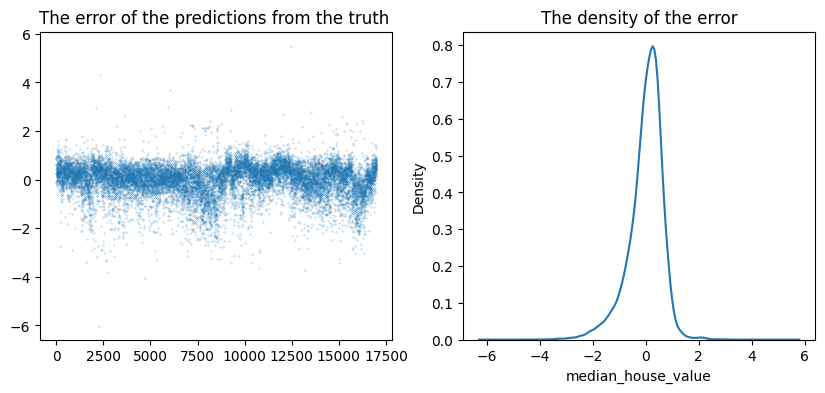

In [16]:
# Plot the errors and density (sanity check):
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10,4))
error = (np.matmul( X, weights_rounded)-Y)
ax1.scatter(range(Y.shape[0]), error ,s=0.05,alpha=0.7)
ax1.set_title("The error of the predictions from the truth ")
sns.kdeplot(error,ax=ax2)
ax2.set_title("The density of the error")
fig.show()


### 1.2 Calculating the weights using numpy and gradient descent (30pts)

Now you are ready to implement an algorithm that iteratively calculates the weights using numpy and gradient descent.

Please fill in your code in the `### YOUR CODE HERE` sections in the code block below.   
Please don't change the other parts of the code (unless specified).  

An epoch in machine learning means one complete pass of the training dataset through the algorithm.   

While developing your code, you may reduce the number of epochs.   
However, for final output please use the pre-defined epochs number.      





In [17]:
t2 = time.time()

# Randomly initialize weights using numpy
b0 = np.random.rand()
b1 = np.random.rand()
b2 = np.random.rand()
b3 = np.random.rand()
b4 = np.random.rand()
b5 = np.random.rand()
b6 = np.random.rand()

# Set learning rate (this can be a little fiddly, requires some tunning)
# Tip: start with a very small steps...

learning_rate = 0.001

# Set number of epochs:
epochs = int(5e3)

# Loop through epochs, and apply gradient descent to update the weights:
for t in range(epochs):
    # Forward pass: compute predicted y
    # y_pred = b0x0 + b1x1 + b2x2 + b3x3 + b4x4 + b5x5 + b6x6
    Y_pred = b0 + b1*X[:, 0] + b2*X[:, 1] + b3*X[:, 2] + b4*X[:, 3] + b5*X[:, 4] + b6*X[:, 5]

    # Compute and print loss
    loss = np.sum((Y_pred - Y)**2) / X.shape[0] # MSE loss
    if t % 1000 == 0:
        print(f"Epoch:{t}, loss:{loss}")

    # Backprop to compute gradients of betas with respect to loss
    grad_y_pred = 2.0 * (Y_pred - Y) / X.shape[0]
    grad_b0 = np.sum(grad_y_pred)
    grad_b1 = np.sum(grad_y_pred * X[:, 0])
    grad_b2 = np.sum(grad_y_pred * X[:, 1])
    grad_b3 = np.sum(grad_y_pred * X[:, 2])
    grad_b4 = np.sum(grad_y_pred * X[:, 3])
    grad_b5 = np.sum(grad_y_pred * X[:, 4])
    grad_b6 = np.sum(grad_y_pred * X[:, 5])

    # Update weights
    b0 -= learning_rate*grad_b0
    b1 -= learning_rate*grad_b1
    b2 -= learning_rate*grad_b2
    b3 -= learning_rate*grad_b3
    b4 -= learning_rate*grad_b4
    b5 -= learning_rate*grad_b5
    b6 -= learning_rate*grad_b6

print(f"Result: y_hat = {b0} x0 + {b1} x1 + {b2} x2 + {b3} x3\n + {b4} x4 + {b5} x5 + {b6} x6 \n")
print(f"Total process time: {round(time.time() - t2,3)}")

weights_gd_rounded = np.array([b0,b1,b2,b3,b4,b5,b6])
print(f"The estimated weights using the gradient descent solution:\n {weights_gd_rounded.round(3)}")

Epoch:0, loss:4.77319576627598
Epoch:1000, loss:0.9900245432024043
Epoch:2000, loss:0.9366795755285962
Epoch:3000, loss:0.9094005977734659
Epoch:4000, loss:0.8933633419229006
Result: y_hat = -0.09757096868106704 x0 + 0.09757097122517275 x1 + 0.17242203016454646 x2 + 0.5576071336523357 x3
 + -0.11095034728924497 x4 + -0.2919112957810474 x5 + -0.03949575964329593 x6 

Total process time: 7.698
The estimated weights using the gradient descent solution:
 [-0.098  0.098  0.172  0.558 -0.111 -0.292 -0.039]


### 1.3 Calculating the weights using PyTorch Tensors and gradient descent (25pts)

Here you are asked to implement the same manual gradient algorithm as above.  
However, this time please use PyTorch tensors and operators (instead of numpy).  

In [18]:
# Creating data and target tensors:
tX = torch.tensor(X)
tY = torch.tensor(Y)

t3 = time.time()

# Randomly initialize weights using PyTorch
tb0 = torch.rand(1)
tb1 = torch.rand(1)
tb2 = torch.rand(1)
tb3 = torch.rand(1)
tb4 = torch.rand(1)
tb5 = torch.rand(1)
tb6 = torch.rand(1)

# Set learning rate
learning_rate = 0.001

# Set number of epochs:
epochs = int(5e3)

# Loop through epochs, and apply gradient descent to update the weights:
for t in range(epochs):
    # Forward pass: compute predicted y
    # y_pred = b0x0 + b1x1 + b2x2 + b3x3 + b4x4 + b5x5 + b6x6
    tY_pred = tb0 + tb1 * tX[:, 0] + tb2 * tX[:, 1] + tb3 * tX[:, 2] + tb4 * tX[:, 3] + tb5 * tX[:, 4] + tb6 * tX[:, 5]

    # Compute and print loss
    loss = torch.sum(torch.pow(tY_pred - tY, 2)) /  X.shape[0] # MSE loss
    if t % 1000 == 0:
        print(f"epoch:{t}, loss:{loss}")

    # Backprop to compute gradients of betas with respect to loss
    grad_y_pred = 2.0 * (tY_pred - tY) / tX.size(0)
    grad_b0 = torch.sum(grad_y_pred)
    grad_b1 = torch.sum(grad_y_pred * tX[:, 0])
    grad_b2 = torch.sum(grad_y_pred * tX[:, 1])
    grad_b3 = torch.sum(grad_y_pred * tX[:, 2])
    grad_b4 = torch.sum(grad_y_pred * tX[:, 3])
    grad_b5 = torch.sum(grad_y_pred * tX[:, 4])
    grad_b6 = torch.sum(grad_y_pred * tX[:, 5])

    # Update weights
    tb0 -= learning_rate * grad_b0
    tb1 -= learning_rate * grad_b1
    tb2 -= learning_rate * grad_b2
    tb3 -= learning_rate * grad_b3
    tb4 -= learning_rate * grad_b4
    tb5 -= learning_rate * grad_b5
    tb6 -= learning_rate * grad_b6

print(f"Result: y_hat = {tb0} x0 + {tb1} x1 + {tb2} x2 + {tb3} x3\n + {tb4} x4 + {tb5} x5 + {tb6} x6 \n")
print(f"Total process time: {round(time.time() - t3,3)}")

weights_gd_tensors_rounded = np.array([tb0.item(),tb1.item(),tb2.item(),tb3.item(),
                                       tb4.item(),tb5.item(),tb6.item()])
print(f"The estimated weights using the gradient descent on tensors:\n {weights_gd_tensors_rounded.round(3)}")

epoch:0, loss:5.3729405046636725
epoch:1000, loss:0.9373562342548925
epoch:2000, loss:0.8996632796847831
epoch:3000, loss:0.8864658427900832
epoch:4000, loss:0.8783680067634553
Result: y_hat = tensor([0.0044], device='cuda:0') x0 + tensor([-0.0044], device='cuda:0') x1 + tensor([0.1725], device='cuda:0') x2 + tensor([0.5768], device='cuda:0') x3
 + tensor([-0.1603], device='cuda:0') x4 + tensor([-0.3994], device='cuda:0') x5 + tensor([0.0939], device='cuda:0') x6 

Total process time: 3.916
The estimated weights using the gradient descent on tensors:
 [ 0.004 -0.004  0.173  0.577 -0.16  -0.399  0.094]


### 1.4 Calculating the weights using PyTorch Autograd! (15pts)

Lastly, you can finally make a full transition to PyTorch autograd framework.   
Please replace your manual gradient calculations with PyTorch's automatic gradient tracking.   
In addition, instead of declaring the parameters separately, we will use one tensor to represent all of the model's parameters.  

In [10]:
t4 = time.time()

# Randomly initialize weights using PyTorch
# we can use 1x7 tensor for all the weights. Make sure `requires_grad = True`.
tb = torch.rand(7, 1, dtype=torch.float32, device=tX.device, requires_grad=True)

# Set learning rate
learning_rate = 0.001
# Set number of epochs:
epochs = int(5e3)

# Loop through epochs, and apply gradient descent to update the weights:
for t in range(epochs):

    # Forward pass: compute predicted y
    tY_pred = tX.float() @ tb # Convert tX to float32

    # Compute and print loss
    loss = torch.sum(torch.pow(tY_pred - tY.view(-1, 1), 2)) / tX.size(0)
    if t % 1000 == 0:
        print(f"epoch:{t}, loss:{loss.item()}")

    # Backprop to compute gradients of betas with respect to loss
    loss.backward()

    with torch.no_grad():
        # Update weights
        tb -= learning_rate * tb.grad
        tb.grad = None # manually clear gradient after update


print(f"Result: betas = {tb} \n")
print(f"Total process time: {round(time.time() - t4,3)}")

weights_autograd_rounded = tb.cpu().detach().numpy()
print(f"The estimated weights using the pytorch autograd:\n {weights_autograd_rounded.round(3)}")

epoch:0, loss:2.087169906039649
epoch:1000, loss:0.471642448930179
epoch:2000, loss:0.44694630764389537
epoch:3000, loss:0.4418351941303312
epoch:4000, loss:0.43849706908021774
Result: betas = tensor([[ 1.7786e-05],
        [ 2.1332e-01],
        [-1.2016e-01],
        [ 1.4362e-01],
        [-2.9668e-01],
        [ 3.4895e-01],
        [ 7.3621e-01]], device='cuda:0', requires_grad=True) 

Total process time: 3.445
The estimated weights using the pytorch autograd:
 [[ 0.   ]
 [ 0.213]
 [-0.12 ]
 [ 0.144]
 [-0.297]
 [ 0.349]
 [ 0.736]]


### 1.5 Conclusion (15pts)

1. Which method is the most accurate in finding the "true" weights? Why? Is it always applicabale? Hint - you should think about it from a statistical theory point of view.
2. Why did we scale the data ?  (answer with respect to the model/algorithm)
3. Do you think our model specification produced good results?  Why or why not? Justify your answer.
4. What can you say about the total process times between methods?
5. Can you suggest some improvements to the model definition?
6. Can you suggest some improvements to the solution algorithm?

YOUR ANSWERS HERE

1. The analytic solution is the most accurate method for finding the "true" weights. The Normal Equation provides the exact, closed-form solution for the weights that globally minimizes the MSE loss. It does not rely on iterative approximation like Gradient Descent. It is not always applicable, it requires the matrix $\mathbf{X}^T\mathbf{X}$ to be invertible.
2. The scaling was preformed in the GD algorithm, to ensure stability of convergence. Without scaling, features with large ranges dominate the loss function, causing GD to converge slow with many iterations. Scaling allows less iterations.
3. The final model specification likely did **not** produce good results relatively. While PyTorch Autograd solution improved the final MSE loss to 0.44 (compared to 0.9 from before), it is still a high value after scaling. The reasom may be that the linear model assumed relationships between features and y_pred.Real-world data is complex with non-linear relationships and feature interactions which the model was not able to copy.
4. Total process time for each method:
* Analitical method - 0.002, single direct calculation
* numpy and GD - 7.698,
* PyTorch Tensors and GD - 3.916,
* PyTorch Autograd - 3.445, fastest iterative method due to torch optimized tenzor multiplications
We can see that the calculating wights analiticaly is the fastest and numpy GD is slowest.
5. To improve predictive power, the model definition needs to capture non-linearity and interactions. It can be done by adding new features that are the product of existing features. Or adding higher-order features, to model curvilinear relationships.
6. The algorithm can also be improved: In GD for example optimizers like ADAM can improve results by tuning learning rate and converging much faster. Also MBGD can be implemented to calculate gradients on smaller batches to reduce the computation time per update => reducing total runtime